[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_1.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_1.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_1.ipynb)

### based on Fig. 1 from Wojciech Grabowski and Hanna Pawlowska 2023 (Geophysical Research Letters 50(3)) 'Adiabatic Evolution of Cloud Droplet Spectral Width: A New Look at an Old Problem'

https://doi.org/10.1029/2022GL101917

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open-atmos-jupyter-utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [5]:
import numpy as np
import os
from matplotlib import pyplot
from matplotlib import ticker
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from PySDM.products import (
    ParcelDisplacement, AmbientRelativeHumidity
)
TRIVIA = Formulae().trivia

from PySDM_examples.Grabowski_and_Pawlowska_2023 import Settings, Simulation

In [3]:
products=(
    ParcelDisplacement(
        name='z'),
    AmbientRelativeHumidity(
        name='S_max', unit='%', var='RH'),
)

vertical_velocity = 0.25 * si.m / si.s
output = {
    case: Simulation(Settings(
        vertical_velocity=vertical_velocity,
        dt=1*si.s if 'CI' not in os.environ else 50 * si.s,
        n_sd=200 if 'CI' not in os.environ else 10,
        aerosol=case
    ), products=products).run()
    for case in ("pristine", "polluted")
}


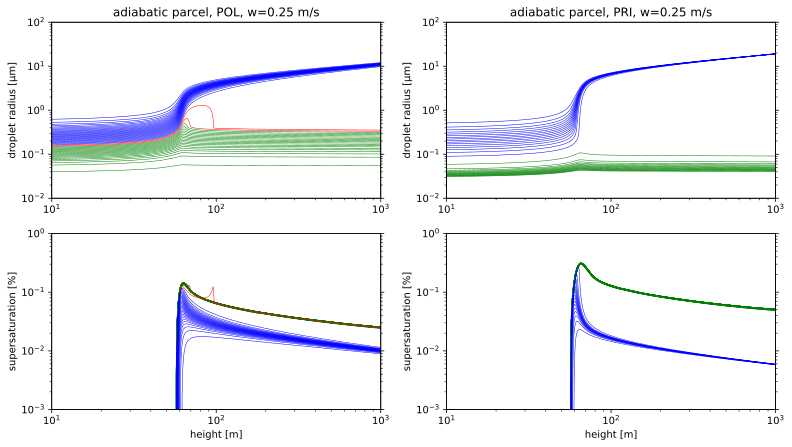

HTML(value="<a href='./fig1.pdf' target='_blank'>./fig1.pdf</a><br>")

In [4]:
# pylint: disable=too-many-arguments
def plot_R(axes, output_vol, output_crit_vol, output_z, k):
    for drop_id, volume in enumerate(output_vol):
        if drop_id%k==0:
            if TRIVIA.radius(volume=volume)[10]>0.03*si.um:
                crit_volume=output_crit_vol[drop_id]
                if np.all(volume<crit_volume):
                    axes.plot(
                        output_z,
                        TRIVIA.radius(volume=volume) / si.um,
                        linewidth=0.5,
                        color='green'
                    )
                elif volume[-1]<crit_volume[-1]:
                    axes.plot(
                        output_z,
                        TRIVIA.radius(volume=volume)/ si.um,
                        linewidth=0.5,
                        color='red'
                    )       
                else:
                    axes.plot(
                        output_z,
                        TRIVIA.radius(volume=volume) / si.um,
                        linewidth=0.5,
                        color='blue'
                    )

def plot_S(axes, output_Seq, output_vol, output_crit_vol, output_z, k):
    for drop_id, S_eq in enumerate(output_Seq):
        if drop_id%k==0:
            volume=output_vol[drop_id]
            crit_volume=output_crit_vol[drop_id]
            if TRIVIA.radius(volume=volume[10])>0.03*si.um:
                if np.all(volume<crit_volume):
                    axes.plot(
                        output_z,
                        (S_eq-1)*100,        
                        color='green')
                elif volume[-1]<crit_volume[-1]:
                    axes.plot(
                        output_z,
                        (S_eq-1)*100,
                        linewidth=0.5,
                        color='red')   
                else:
                    axes.plot(
                        output_z,
                        (S_eq-1)*100,
                        linewidth=0.5,
                        color='blue')              
                    

fig, axs = pyplot.subplots(2, 2, figsize=(13, 7))
axS1, axS2, axR1, axR2 = [axs[1,0], axs[1,1], axs[0,0], axs[0,1]]

for aerosol, i in (("polluted",0),("pristine",1)):
    axs[1,i].plot(output[aerosol]['products']['z'],np.asarray(output[aerosol]['products']['S_max'])-100, color='black')
    plot_S(axs[1,i],np.asarray(output[aerosol]['attributes']['equilibrium supersaturation']),np.asarray(output[aerosol]['attributes']['volume']),np.asarray(output[aerosol]['attributes']['critical volume']),np.asarray(output[aerosol]['products']['z']),4)
    plot_R(axs[0,i],np.asarray(output[aerosol]['attributes']['volume']),np.asarray(output[aerosol]['attributes']['critical volume']),np.asarray(output[aerosol]['products']['z']),4)

axS1_, axS2_, axR1_, axR2_ = [axS1.twinx(),axS2.twinx(),axR1.twinx(),axR2.twinx()]
for ax in [axS1, axS1_, axS2, axS2_, axR1, axR1_, axR2, axR2_]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(10, 1000)
for ax in [axS1,axS1_,axS2,axS2_]:
    ax.set_ylim(0.001, 1)
for ax in [axR1,axR1_,axR2,axR2_]:
    ax.set_ylim(0.01, 100)
for ax in [axR1,axR2]:
    ax.set_ylabel('droplet radius [μm]')
axR1.set_title(f'adiabatic parcel, POL, w={vertical_velocity} m/s')
axR2.set_title(f'adiabatic parcel, PRI, w={vertical_velocity} m/s')
for ax in [axS1,axS2]:
    ax.set_xlabel('height [m]')
    ax.set_ylabel('supersaturation [%]') 
for ax in [axS1_,axS2_,axR1_,axR2_]:
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
show_plot("fig1.pdf")